# **TA #5 - Python version**

## Foundation of Econometrics - DSDM 2025-2026

**Lucia Sauer**

**Contact:** [lucia.sauer@bse.eu](mailto:lucia.sauer@bse.eu)

In this notebook we will review:

- Visual Inspection of Heteroskedasticity
- Testing for Heteroskedasticity: Breusch-Pagan Test
- Classical vs. Robust Standard Errors
- Bootstrapped Standard Errors in Stata/Python
- Clustered Data and Cluster-Robust Standard Errors



In [1]:
import wooldridge as woo
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.api import DescrStatsW
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.formula.api import ols
from scipy.stats import norm
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context = 'talk')

In [2]:
df = woo.data('hprice3')

### **Main Model**

$$ 
price_i = \beta_1 + \beta_2 area_i + \beta_3 rooms_i + \epsilon_i 
$$

In [3]:
model = sm.OLS(df["price"], sm.add_constant(df[["area", "rooms"]])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     120.0
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           1.52e-39
Time:                        13:31:58   Log-Likelihood:                -3791.2
No. Observations:                 321   AIC:                             7588.
Df Residuals:                     318   BIC:                             7600.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.231e+04   1.36e+04     -1.637      0.1

### **Visual Inspection of Heteroskedasticity**

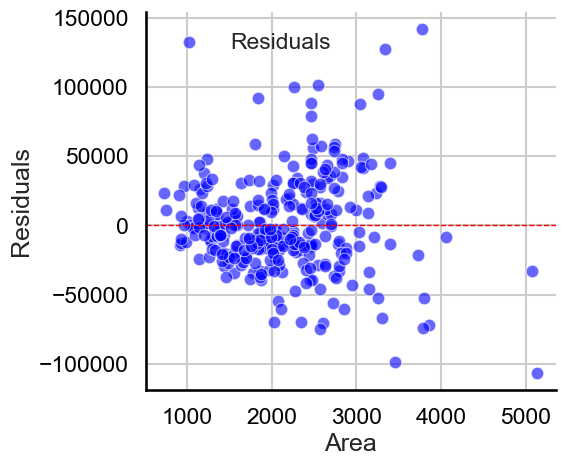

In [4]:
# Residuals vs area
fig, ax = plt.subplots(figsize=(6,5))
sns.scatterplot(x=df["area"], y=model.resid, color="blue", alpha=0.6, ax=ax, label="Residuals")
plt.xlabel("Area")
plt.ylabel("Residuals")
plt.axhline(0, color="red", ls="--", lw=1)
# Hide top and right spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set bottom and left spines to black
ax.spines["bottom"].set_color("black")
ax.spines["left"].set_color("black")
# Set tick color to black
ax.tick_params(axis="x", colors="black")
ax.tick_params(axis="y", colors="black")

plt.tight_layout()

plt.legend(frameon=False)
plt.show()


### **Testing for Heteroskedasticity: Breusch-Pagan Test**

In [5]:
# --- 4. Breusch–Pagan Test ----------------------------------
# The test regresses squared residuals on regressors
bp_test = het_breuschpagan(model.resid, sm.add_constant(df[["area", "rooms"]]))
bp_labels = ["LM Statistic", "LM-Test p-value", "F-Statistic", "F-Test p-value"]
bp_results = dict(zip(bp_labels, bp_test))
print("\nBreusch–Pagan Test Results:")
for k,v in bp_results.items():
    print(f"{k}: {v:.4f}")



Breusch–Pagan Test Results:
LM Statistic: 58.3584
LM-Test p-value: 0.0000
F-Statistic: 35.3295
F-Test p-value: 0.0000


In [6]:
# --- 5. Robust (HC) Standard Errors --------------------------
ols_robust = model.get_robustcov_results(cov_type='HC1')
print("\nRobust SEs (HC1):")
print(ols_robust.summary())



Robust SEs (HC1):
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     80.07
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           6.88e-29
Time:                        13:31:58   Log-Likelihood:                -3791.2
No. Observations:                 321   AIC:                             7588.
Df Residuals:                     318   BIC:                             7600.
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.231e+04   1.21e+04 

In [7]:
# --- 6. Bootstrapped Standard Errors -------------------------
def ols_bootstrap(data, formula, n_boot=500, seed=123):
    """
    Performs bootstrap for OLS coefficients.
    Returns (std errors, all bootstrap coefficients).
    """
    np.random.seed(seed)
    coefs = []
    for _ in range(n_boot):
        sample = data.sample(frac=1, replace=True)
        res = smf.ols(formula, data=sample).fit()
        coefs.append(res.params)
    coefs = pd.DataFrame(coefs)
    return coefs.std(), coefs

boot_se, boot_coefs = ols_bootstrap(df, "price ~ area + rooms")

print("\nBootstrap SEs (500 replications):")
print(boot_se)



Bootstrap SEs (500 replications):
Intercept    12463.738994
area             4.854917
rooms         2541.557103
dtype: float64


In [8]:
boot_se.index = boot_se.index.str.replace("Intercept", "const")

params = model.params

# Combine everything in one table
df_boot = pd.DataFrame({
    "Variable": params.index,
    "Coefficient": params.values,
    "Bootstrap_SE": boot_se.reindex(params.index).values
})
df_boot.set_index("Variable", inplace=True)

# Compute t-stats, p-values, and confidence intervals
df_boot["t"] = df_boot["Coefficient"] / df_boot["Bootstrap_SE"]
df_boot["p>|t|"] = 2 * (1 - norm.cdf(np.abs(df_boot["t"])))
df_boot["[0.025"] = df_boot["Coefficient"] - 1.96 * df_boot["Bootstrap_SE"]
df_boot["0.975]"] = df_boot["Coefficient"] + 1.96 * df_boot["Bootstrap_SE"]

# Round for presentation
df_boot = df_boot.round(4)

print("\nBootstrap OLS Regression Results (500 replications):")
print(df_boot)


Bootstrap OLS Regression Results (500 replications):
          Coefficient  Bootstrap_SE       t   p>|t|      [0.025      0.975]
Variable                                                                   
const     -22314.8520    12463.7390 -1.7904  0.0734 -46743.7805   2114.0764
area          35.5631        4.8549  7.3252  0.0000     26.0474     45.0787
rooms       6604.3052     2541.5571  2.5985  0.0094   1622.8532  11585.7571


# **Clustered Data**


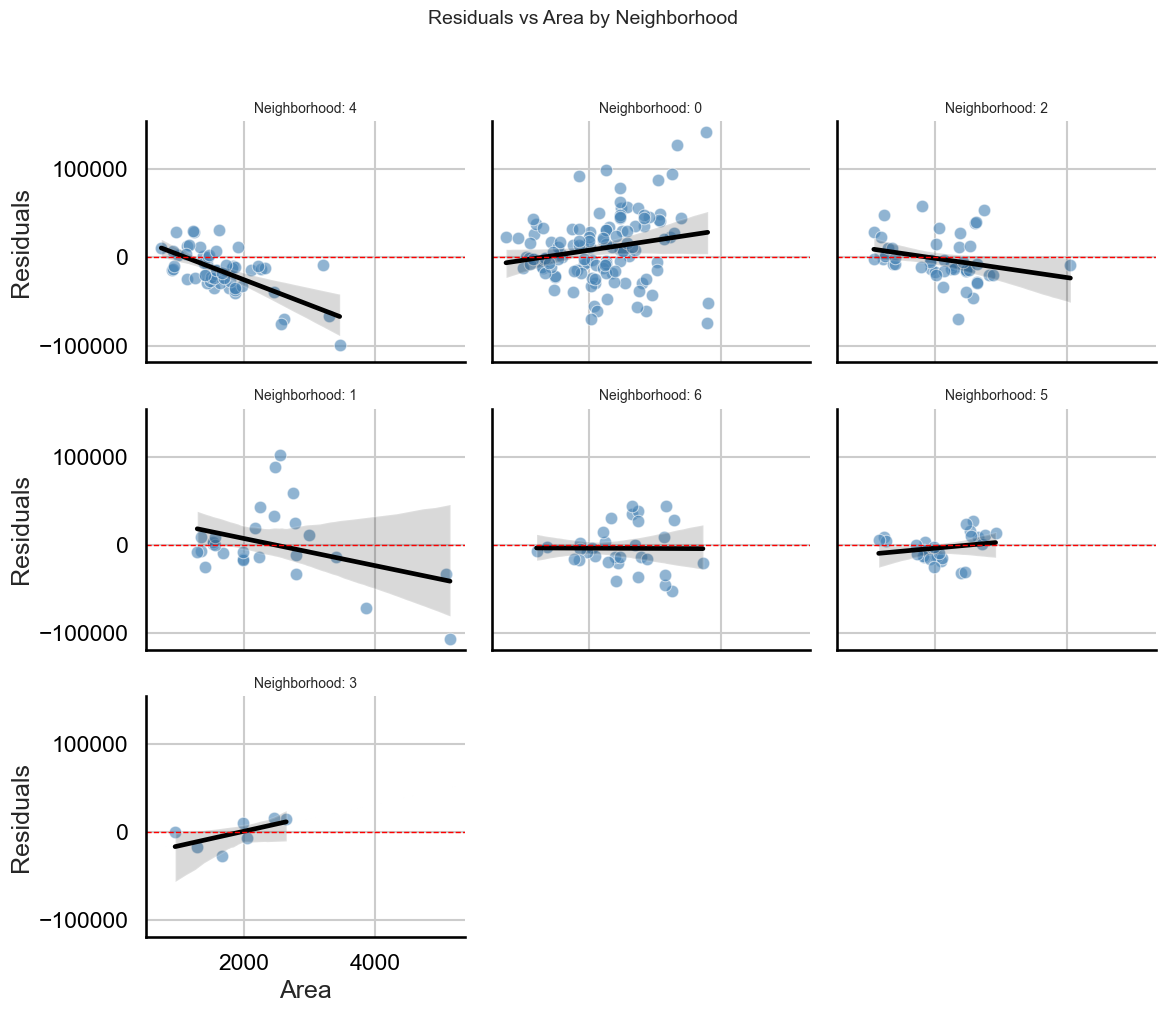

In [9]:
# Unique neighborhoods
neighborhoods = df["nbh"].unique()
n_neigh = len(neighborhoods)

# Define grid dimensions (3x3 is enough for 7 neighborhoods)
n_rows, n_cols = 3, 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten so we can iterate over a simple list of Axes

# Loop through neighborhoods
for i, nbh in enumerate(neighborhoods):
    ax = axes[i]
    subset = df[df["nbh"] == nbh]
    
    sns.scatterplot(
        x=subset["area"], 
        y=model.resid[subset.index],
        color="steelblue", alpha=0.6, ax=ax
    )
    #fit the regression line
    sns.regplot(
        x=subset["area"], 
        y=model.resid[subset.index],
        scatter=False, ax=ax, color="black"
    )
    
    ax.axhline(0, color="red", ls="--", lw=1)
    ax.set_title(f"Neighborhood: {nbh}", fontsize=10)
    ax.set_xlabel("Area")
    ax.set_ylabel("Residuals")

    # Aesthetic cleanup
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.tick_params(axis="x", colors="black")
    ax.tick_params(axis="y", colors="black")

# Turn off any unused subplots (e.g., for 7/9)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Residuals vs Area by Neighborhood", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


In [10]:
# --- 7. Clustered Standard Errors ----------------------------
# Let's assume 'nbh' is the cluster variable (neighborhood)
ols_cluster = model.get_robustcov_results(cov_type='cluster',
                                          groups=df["nbh"])
print("\nCluster-Robust SEs (by neighborhood):")
print(ols_cluster.summary())



Cluster-Robust SEs (by neighborhood):
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     88.92
Date:                Wed, 22 Oct 2025   Prob (F-statistic):           3.48e-05
Time:                        13:31:59   Log-Likelihood:                -3791.2
No. Observations:                 321   AIC:                             7588.
Df Residuals:                     318   BIC:                             7600.
Df Model:                           2                                         
Covariance Type:              cluster                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2